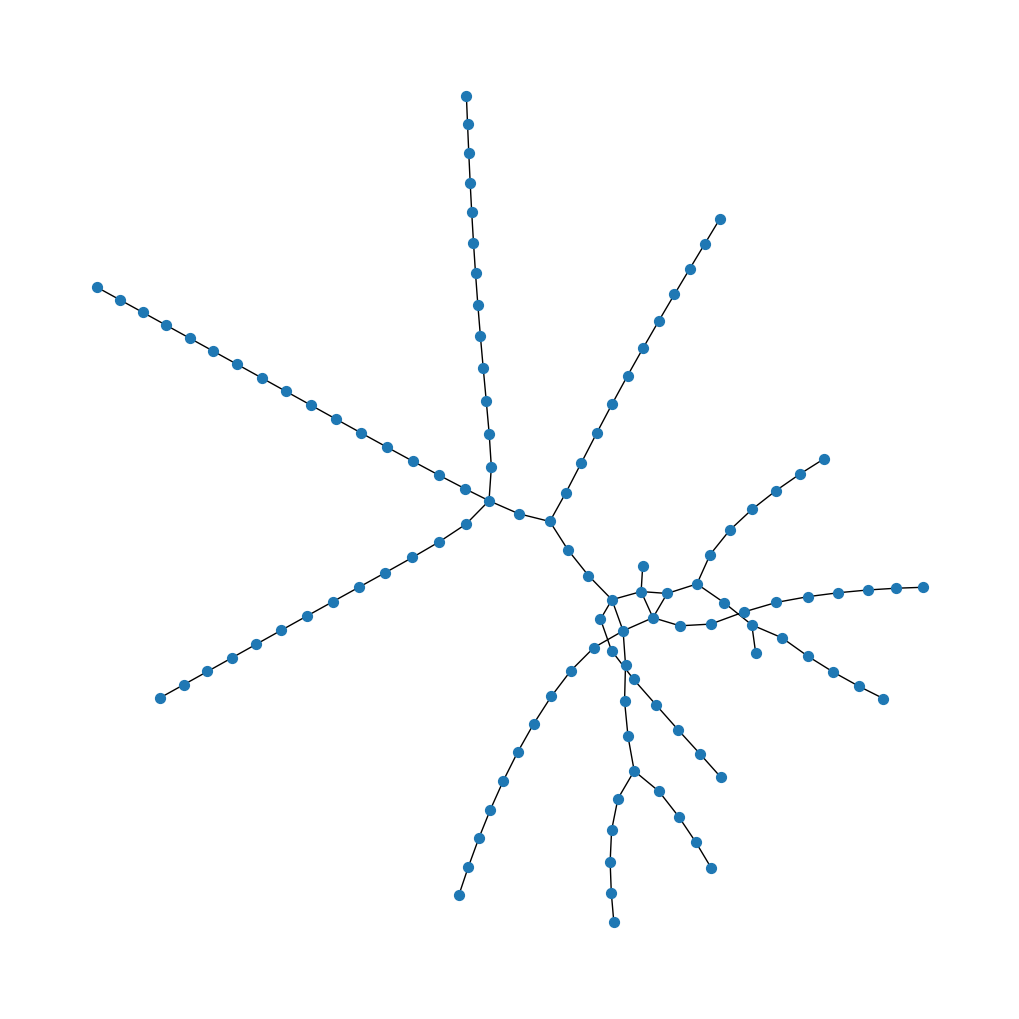

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

def open_line_file(filename):
    with open(f'./Rapid_Transit_Lines/{filename}.txt', 'r') as f:
      lines = f.readlines()
    return lines

line_files = [
    'Red-C1-0',
    'Red-C1-1',
    'Red-C2-0',
    'Red-C2-1',
    'Green-B-C1-0',
    'Green-B-C1-1',
    'Green-C-C1-0',
    'Green-C-C1-1',
    'Green-D-C1-0',
    'Green-D-C1-1',
    'Green-E-C1-0',
    'Green-E-C1-1',
    'Orange-C1-0',
    'Orange-C1-1',
    'Blue-C1-0',
    'Blue-C1-1'
]

line_stations = map(open_line_file, line_files)

stations = set()
edges = set()

for line in line_stations:
    for i in range(len(line)-1):
        stop_name = line[i].rstrip()
        next_stop_name = line[i+1].rstrip()
        stations.add(stop_name)
        edges.add((stop_name, next_stop_name))
    end_stop_name = line[-1].rstrip()
    stations.add(end_stop_name)

network = nx.Graph()
network.add_nodes_from(stations)
network.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
layout = nx.kamada_kawai_layout(network)
nx.draw(network, layout, node_size=50)

## Associating Delay Data

First, we start by opening the delay data JSON and plotting a histogram to get an overview of it.

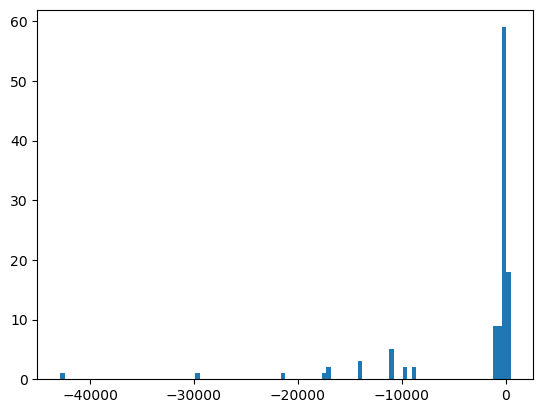

In [11]:
import json

delays_file = open("./Delay_Data/named_rapid_transit_delays.json", 'r')
delays_json = delays_file.read()
delays_file.close()

delays = json.loads(delays_json)
fig, ax = plt.subplots()
hist = ax.hist(delays.values(), bins=100)

We see that we have a handful of extremely negative outliers. We remove the outliers to get a more balanced histogram:

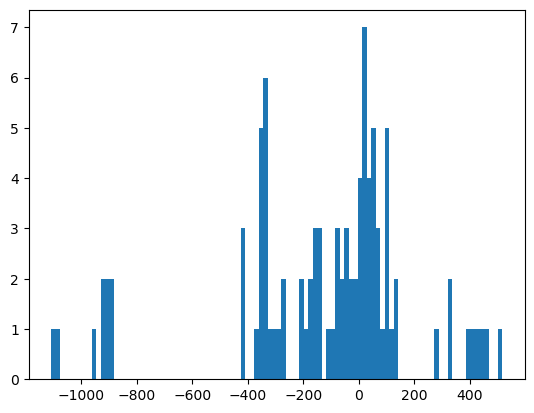

In [12]:
# remove outliers
delays = dict((s, d) for s, d in delays.items() if d > -5000)

fig, ax = plt.subplots()
hist = ax.hist(delays.values(), bins=100)

Now we associate each delay data point with its respective node in our NetworkX network and draw it again, this time coloring the nodes based on whether they have a negative or non-negative average delay, or if we have no delay data.

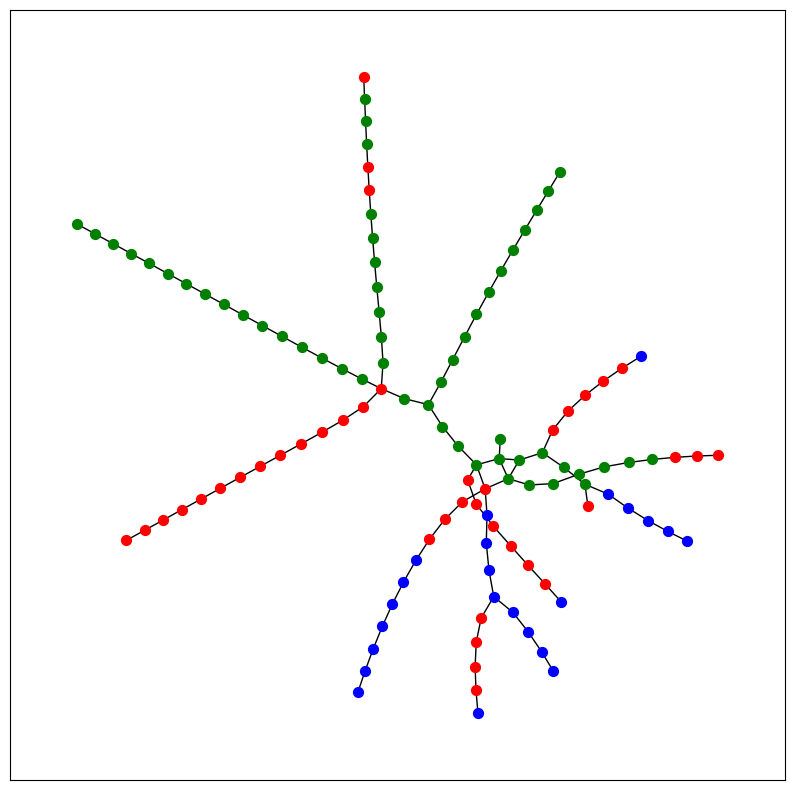

In [13]:
nx.set_node_attributes(network, delays, "avg_delay")

# proof of concept for coloring nodes; for now just split into positive and negative delays
# later we can split into bins
nonnegative_delay_nodes = [n for (n, delay) in nx.get_node_attributes(network, "avg_delay").items() if delay >= 0]
negative_delay_nodes = [n for (n, delay) in nx.get_node_attributes(network, "avg_delay").items() if delay < 0]
remaining_nodes = list(set(network.nodes()) - set(nonnegative_delay_nodes) - set(negative_delay_nodes))

fig = plt.figure(figsize = (10,10))
layout = nx.kamada_kawai_layout(network)
nx.draw_networkx_nodes(network, layout, nodelist=nonnegative_delay_nodes, node_color='red', node_size=50)
nx.draw_networkx_nodes(network, layout, nodelist=negative_delay_nodes, node_color='green', node_size=50)
nx.draw_networkx_nodes(network, layout, nodelist=remaining_nodes, node_color='blue', node_size=50)
nx.draw_networkx_edges(network, layout)

## Further Analysis

Let's see if there's any correlation between node centrality and average delay. Here we use Katz Centrality with an alpha value of 0.1.

In [14]:
avg_delay = nx.get_node_attributes(network, "avg_delay")

# Calculate the Katz centrality for each node
katz_centrality = nx.katz_centrality(network, alpha=0.1)
between_centrality = nx.betweenness_centrality(network)
eig_centrality = nx.eigenvector_centrality(network)
deg_centrality = nx.degree_centrality(network)


# Nothing compare the average delay with the Katz centrality for each node
for (node, delay) in nx.get_node_attributes(network, "avg_delay").items():
    print(f"Node {node}:")
    print(f"  Average delay: {delay}")
    print(f"  Katz centrality: {katz_centrality[node]}")

print(avg_delay.values())

Node Government Center:
  Average delay: -43.75
  Katz centrality: 0.11514729072609203
Node Arlington:
  Average delay: -151.083333333333
  Katz centrality: 0.09245112375360283
Node Suffolk Downs:
  Average delay: -22.75
  Katz centrality: 0.09123182755813347
Node Cleveland Circle:
  Average delay: 25.0
  Katz centrality: 0.08202406160539107
Node Newton Centre:
  Average delay: 3.2
  Katz centrality: 0.09124120712785891
Node Dean Road:
  Average delay: 48.0
  Katz centrality: 0.09114724121812391
Node Brigham Circle:
  Average delay: -903.75
  Katz centrality: 0.09124121704031435
Node Malden Center:
  Average delay: 95.0
  Katz centrality: 0.0903102884950344
Node Fenwood Road:
  Average delay: -885.75
  Katz centrality: 0.09124034513109816
Node Aquarium:
  Average delay: -78.75
  Katz centrality: 0.09374166386127511
Node Allston Street:
  Average delay: -361.8
  Katz centrality: 0.0912413028436382
Node Beachmont:
  Average delay: 28.0
  Katz centrality: 0.09114724367798951
Node Reservoi

In [15]:
import pandas as pd

df = pd.DataFrame(list(zip(avg_delay.values(), katz_centrality.values(), between_centrality.values(), eig_centrality.values(), deg_centrality.values())), columns=["avg_delay", "katz_centrality", "bet_centrality", "eig_centrality", "deg_centrality"])

# Calculate the correlation coefficient between the two variables
katz_cor = df["avg_delay"].corr(df["katz_centrality"])
print("Correlation Coefficient of avg_delay and katz centrality: " + str(katz_cor))

bet_cor = df["avg_delay"].corr(df["bet_centrality"])
print("Correlation Coefficient of avg_delay and betweennes centrality: " + str(bet_cor))

eig_cor = df["avg_delay"].corr(df["eig_centrality"])
print("Correlation Coefficient of avg_delay and eigenvector centrality: " + str(eig_cor))

deg_cor = df["avg_delay"].corr(df["deg_centrality"])
print("Correlation Coefficient of avg_delay and degree centrality: " + str(deg_cor))

Correlation Coefficient of avg_delay and katz centrality: 0.05930916927611191
Correlation Coefficient of avg_delay and betweennes centrality: 0.046607428534979914
Correlation Coefficient of avg_delay and eigenvector centrality: 0.14684310610570966
Correlation Coefficient of avg_delay and degree centrality: 0.03683873074325735


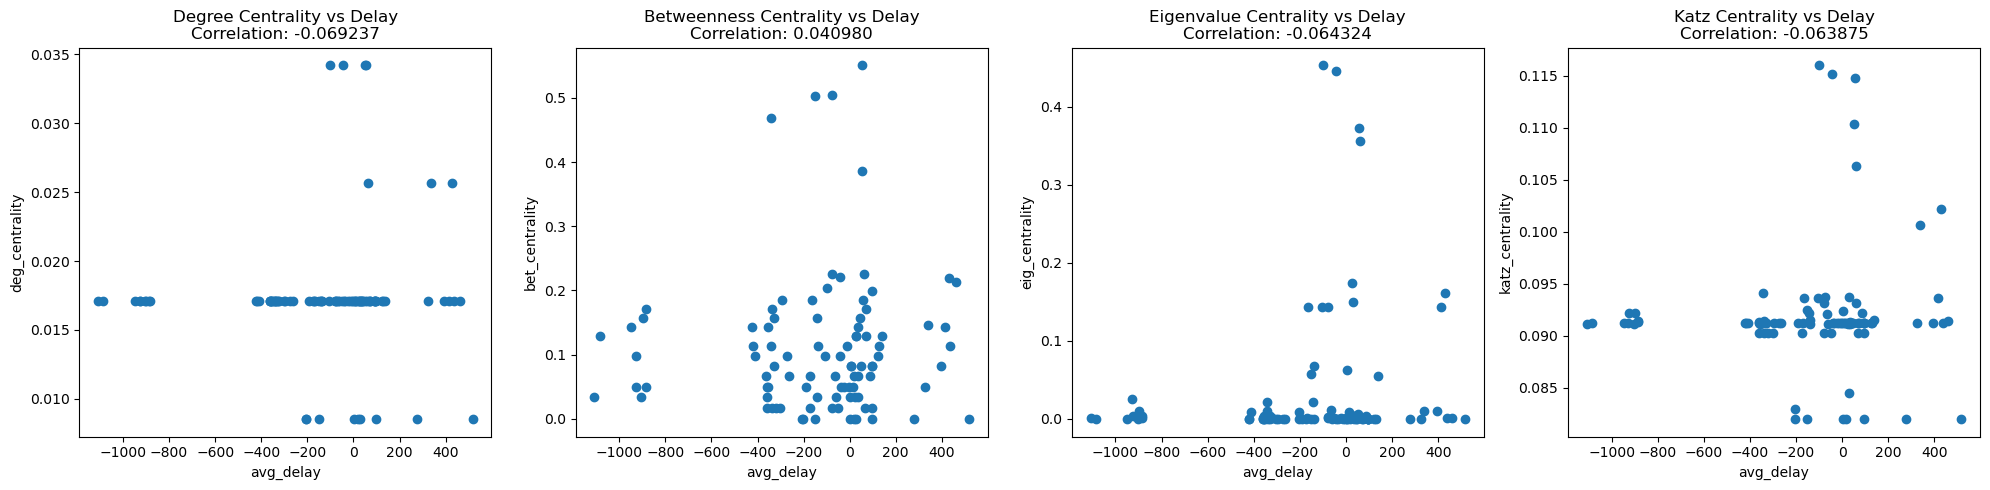

In [16]:
# Create subplots with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Scatter plot for avg_delay vs katz_centrality
axes[3].scatter(df["avg_delay"], df["katz_centrality"])
axes[3].set_title("Katz Centrality vs Delay\nCorrelation: -0.063875")
axes[3].set_xlabel("avg_delay")
axes[3].set_ylabel("katz_centrality")

# Scatter plot for avg_delay vs bet_centrality
axes[1].scatter(df["avg_delay"], df["bet_centrality"])
axes[1].set_title("Betweenness Centrality vs Delay\nCorrelation: 0.040980")
axes[1].set_xlabel("avg_delay")
axes[1].set_ylabel("bet_centrality")

# Scatter plot for avg_delay vs eig_centrality
axes[2].scatter(df["avg_delay"], df["eig_centrality"])
axes[2].set_title("Eigenvalue Centrality vs Delay\nCorrelation: -0.064324")
axes[2].set_xlabel("avg_delay")
axes[2].set_ylabel("eig_centrality")

# Scatter plot for avg_delay vs deg_centrality
axes[0].scatter(df["avg_delay"], df["deg_centrality"])
axes[0].set_title("Degree Centrality vs Delay\nCorrelation: -0.069237")
axes[0].set_xlabel("avg_delay")
axes[0].set_ylabel("deg_centrality")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

Nope. Oh well. Let's take a look at modularity. We'll bin the nodes based on their average delay and then calculate the network's modularity.

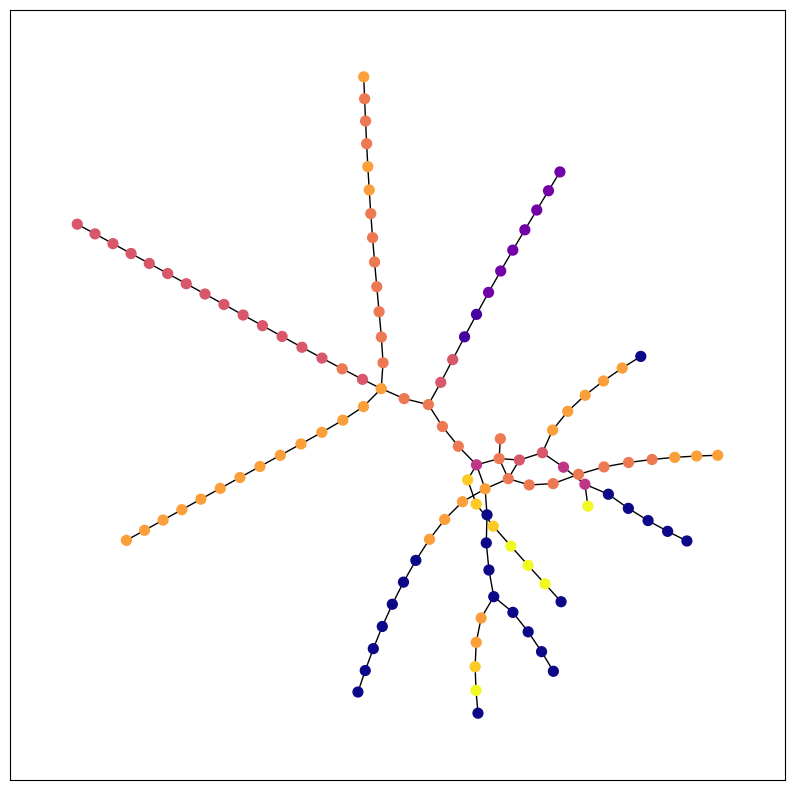

In [17]:
import random
import numpy as np

boundaries = [-1200, -1000, -800, -600, -400, -200, 0, 200, 400]
n_boundaries = len(boundaries)
node_groups = []

# set the bin attribute on each node with delay data
for i in range(n_boundaries):
    if (i == n_boundaries - 1):
        group = list(n for (n, delay) in nx.get_node_attributes(network, 'avg_delay').items() if delay > boundaries[i])
    else:
        group = list(n for (n, delay) in nx.get_node_attributes(network, 'avg_delay').items() if delay > boundaries[i] and delay <= boundaries[i+1])

    attrs = {}
    for n in group:
        attrs[n] = i + 1
    nx.set_node_attributes(network, attrs, 'delay_bin')
    node_groups.append(group)

# set the bin to 0 for nodes without delay data
remaining_nodes = list(set(network.nodes()) - set([n for group in node_groups for n in group]))
node_groups.append(remaining_nodes)
attrs = {}
for n in remaining_nodes:
    attrs[n] = 0
    nx.set_node_attributes(network, attrs, 'delay_bin')

# plot it
fig = plt.figure(figsize = (10,10))
layout = nx.kamada_kawai_layout(network)

bin = np.array(list(nx.get_node_attributes(network, 'delay_bin').values()))

nx.draw_networkx_nodes(network, layout, node_color=bin, cmap='plasma', node_size=50)
nx.draw_networkx_edges(network, layout)

These appear to be very modular!

In [18]:
nx.community.modularity(network, node_groups)

0.5495021538026974

And indeed they are.